In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator,QasmSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import plot_bloch_multivector
from numpy import pi,random
from math import sqrt, atan2,cos,sin,pow
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit.extensions import *
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError,ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.aer.noise import amplitude_damping_error,phase_damping_error,phase_amplitude_damping_error

print('Libraries Loaded!')

Libraries Loaded!


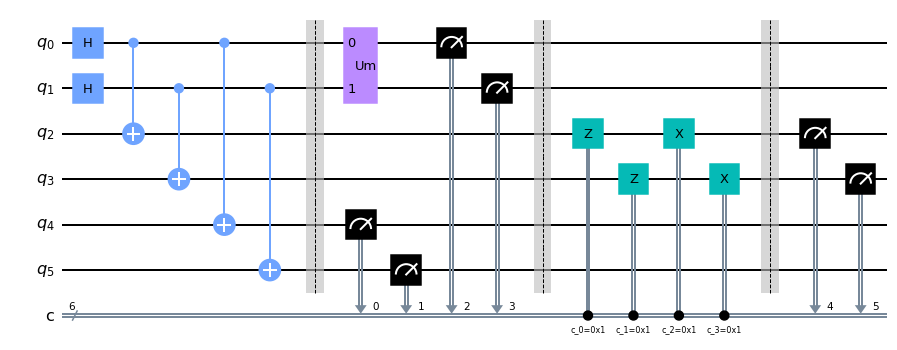

In [3]:
theta = pi/3
a = cos(theta)
b = sin(theta)

U_M = np.array([[a**2,a*b,a*b,b**2],[a*b,-a**2,b**2,-a*b],[a*b,b**2,-a**2,-a*b],[b**2,-a*b,-a*b,a**2]])
U_M_gate = UnitaryGate(U_M,label='Um')


q = QuantumRegister(6, 'q') # |A1 A2 B1 B2 C1 C2>
c = ClassicalRegister(6,'c') # c[0]=M(|C1>), c[1]=M(|C2>), c[2]=M(|A1>), c[3]=M(|A2>), c[4]=M(|B1>), c[5]=M(|B2>)
Qc = QuantumCircuit(q,c)

# Prepare GHZ states
Qc.h(q[0]) # H|A1>
Qc.h(q[1]) # H|A2>
Qc.cx(q[0],q[2]) # |A1> CNOT |B1>
Qc.cx(q[1],q[3]) # |A2> CNOT |B2>
Qc.cx(q[0],q[4]) # |A1> CNOT |C1>
Qc.cx(q[1],q[5]) # |A2> CNOT |C2>
Qc.barrier(q)
# Measure C1 & C2 qubits
Qc.measure(q[4],c[0]) # c[0] = M(|C1>)
Qc.measure(q[5],c[1]) # c[1] = M(|C2>)
# Change basis measurement to the orthonormal basis {|𝜙0⟩, |𝜙1⟩, |𝜙2⟩, |𝜙3⟩}
Qc.append(U_M_gate, [q[0], q[1]])
Qc.measure(q[0],c[2]) # c[2] = M(|A1>)
Qc.measure(q[1],c[3]) # c[3] = M(|A2>)
Qc.barrier(q)
# Apply U gate on A1 & A2 qubits
Qc.z(q[2]).c_if(c[0],1)
Qc.z(q[3]).c_if(c[1],1)
Qc.x(q[2]).c_if(c[2],1)
Qc.x(q[3]).c_if(c[3],1)
Qc.barrier(q)
Qc.measure(q[2],c[4]) # c[4] = M(|B1>)
Qc.measure(q[3],c[5]) # c[5] = M(|B2>)

Qc.draw(output='mpl')


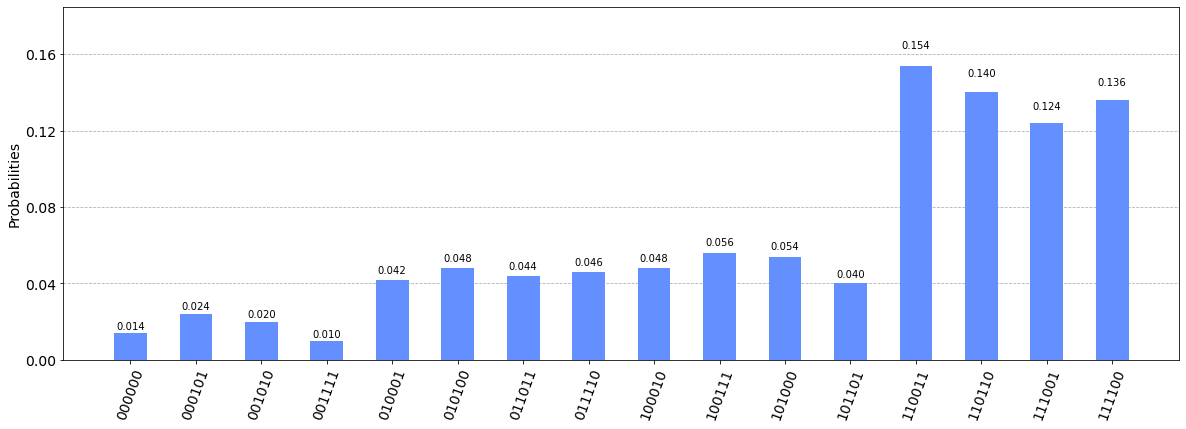

In [10]:
m = 500
simulator = QasmSimulator()#QasmSimulator(method='density_matrix')
circ = transpile(Qc, simulator)
result = simulator.run(circ, shots=m).result()
counts = result.get_counts(circ)
#print(counts)
plot_histogram(counts,[20,6.5])

|X> = a|0> + b|1>
a =  0.5000000000000001
b =  0.8660254037844386
------------------------------------------------------
Measurement results:
|B1B2>=  {'00': 34.0, '01': 90.0, '10': 99.0, '11': 277.0}
|B1>=  {'0': 124.0, '1': 376.0}
|B2>=  {'0': 133.0, '1': 367.0}


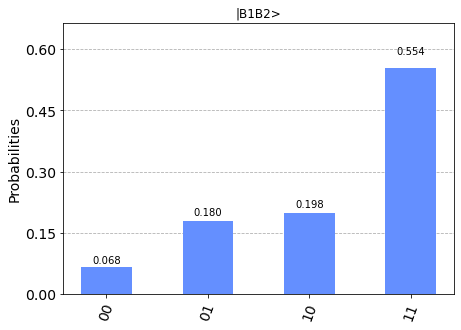

In [11]:
S = np.zeros([8])

for state in counts:    
    if (state[0]=='0')&(state[1]=='0'):
        S[4] = S[4]+counts[state]
        S[0]=S[0]+counts[state]
        S[2]=S[2]+counts[state]
    if (state[0]=='0')&(state[1]=='1'):
        S[5] = S[5]+counts[state]
        S[0]=S[0]+counts[state]
        S[3]=S[3]+counts[state]
    if (state[0]=='1')&(state[1]=='0'):
        S[6] = S[6]+counts[state]
        S[1]=S[1]+counts[state]
        S[2]=S[2]+counts[state]
    if (state[0]=='1')&(state[1]=='1'):
        S[7] = S[7]+counts[state]
        S[1]=S[1]+counts[state]
        S[3]=S[3]+counts[state]
        
count_B1B2 = {'00':S[4],'01':S[5],'10':S[6],'11':S[7]}
count_B1 = {'0':S[0],'1':S[1]}
count_B2 = {'0':S[2],'1':S[3]}
print('|X> = a|0> + b|1>')
print('a = ',a)
print('b = ',b)
print('------------------------------------------------------')
print('Measurement results:')
print('|B1B2>= ',count_B1B2)
print('|B1>= ',count_B1)
print('|B2>= ',count_B2)
plot_histogram(count_B1B2,title='|B1B2>')


|B1>=  {'0': 124.0, '1': 376.0}
|B1> =  0.4979959839195493 |0> +  0.867179335547152 |1>


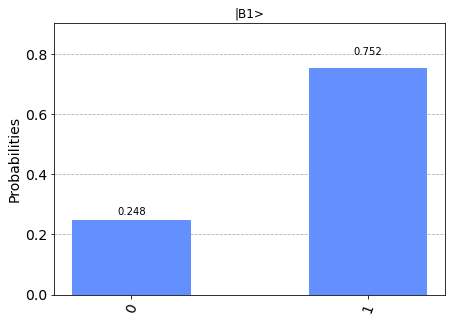

In [12]:
print('|B1>= ',count_B1)
print('|B1> = ',sqrt(count_B1['0']/m),'|0> + ',sqrt(count_B1['1']/m),'|1>')
plot_histogram(count_B1,title='|B1>')

|B2>=  {'0': 133.0, '1': 367.0}
|B2> =  0.5157518783291051 |0> +  0.8567379996241558 |1>


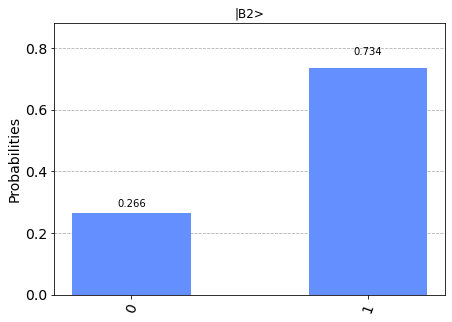

In [13]:
print('|B2>= ',count_B2)
print('|B2> = ',sqrt(count_B2['0']/m),'|0> + ',sqrt(count_B2['1']/m),'|1>')
plot_histogram(count_B2,title='|B2>')

In [99]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error on qubit 2 forall single qubit u1, u2, u3 gates on qubit 0
error = phase_amplitude_damping_error(0.5,0.5)
noise_model.add_quantum_error(error, ['id', 'rz', 'sx','u1', 'u2', 'u3'], [0], [1])
#noise_model.add_all_qubit_quantum_error(error, ['id', 'rz', 'sx','u1', 'u2', 'u3'])


# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'sx', 'rz', 'id', 'u3', 'u2']
  Qubits with noise: [0]
  Specific qubit errors: [('id', (0,)), ('rz', (0,)), ('sx', (0,)), ('u1', (0,)), ('u2', (0,)), ('u3', (0,))]


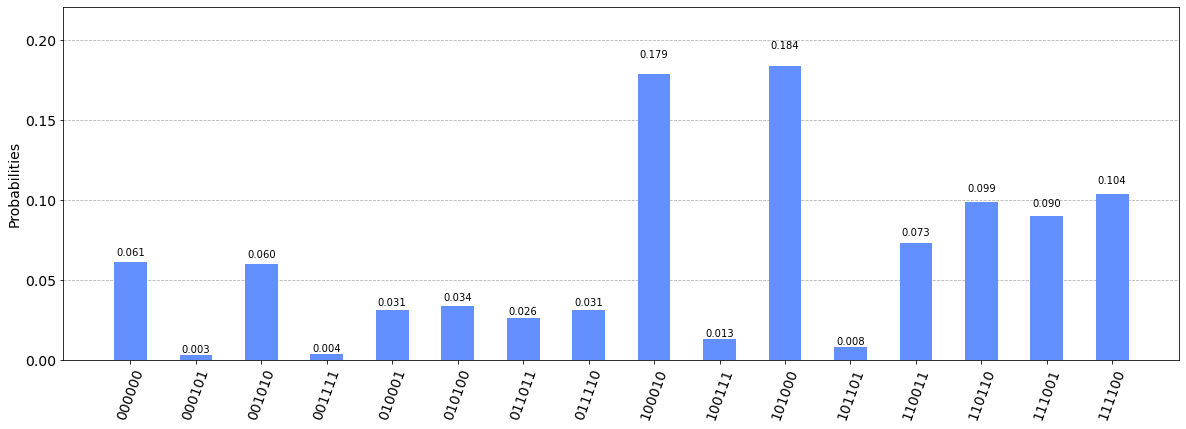

In [100]:
m = 1000
simulator = QasmSimulator(noise_model=noise_model)#QasmSimulator(method='density_matrix')
sim = transpile(Qc, simulator)
result = simulator.run(sim, shots=m).result()
counts = result.get_counts(circ)
#print(counts)
plot_histogram(counts,[20,6.5])

|X> = a|0> + b|1>
a =  0.5000000000000001
b =  0.8660254037844386
------------------------------------------------------
Measurement results:
|B1B2>=  {'00': 128.0, '01': 122.0, '10': 384.0, '11': 366.0}
|B1>=  {'0': 250.0, '1': 750.0}
|B2>=  {'0': 512.0, '1': 488.0}


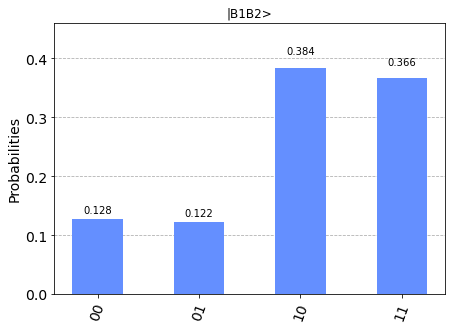

In [101]:
S = np.zeros([8])

for state in counts:    
    if (state[0]=='0')&(state[1]=='0'):
        S[4] = S[4]+counts[state]
        S[0]=S[0]+counts[state]
        S[2]=S[2]+counts[state]
    if (state[0]=='0')&(state[1]=='1'):
        S[5] = S[5]+counts[state]
        S[0]=S[0]+counts[state]
        S[3]=S[3]+counts[state]
    if (state[0]=='1')&(state[1]=='0'):
        S[6] = S[6]+counts[state]
        S[1]=S[1]+counts[state]
        S[2]=S[2]+counts[state]
    if (state[0]=='1')&(state[1]=='1'):
        S[7] = S[7]+counts[state]
        S[1]=S[1]+counts[state]
        S[3]=S[3]+counts[state]
        
count_B1B2 = {'00':S[4],'01':S[5],'10':S[6],'11':S[7]}
count_B1 = {'0':S[0],'1':S[1]}
count_B2 = {'0':S[2],'1':S[3]}
print('|X> = a|0> + b|1>')
print('a = ',a)
print('b = ',b)
print('------------------------------------------------------')
print('Measurement results:')
print('|B1B2>= ',count_B1B2)
print('|B1>= ',count_B1)
print('|B2>= ',count_B2)
plot_histogram(count_B1B2,title='|B1B2>')


|B1>=  {'0': 250.0, '1': 750.0}
|B1> =  0.5 |0> +  0.8660254037844386 |0>


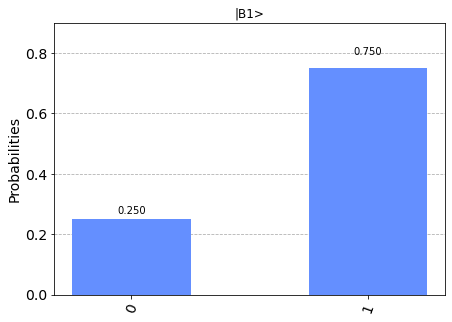

In [102]:
print('|B1>= ',count_B1)
print('|B1> = ',sqrt(count_B1['0']/m),'|0> + ',sqrt(count_B1['1']/m),'|0>')
plot_histogram(count_B1,title='|B1>')

|B2>=  {'0': 512.0, '1': 488.0}
|B2> =  0.7155417527999327 |0> +  0.6985699678629192 |0>


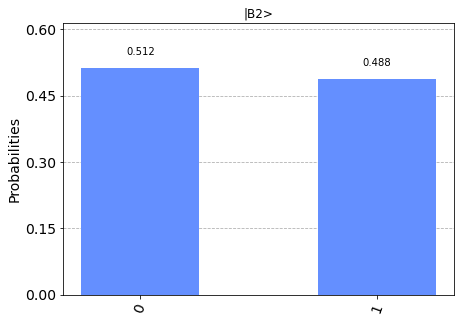

In [103]:
print('|B2>= ',count_B2)
print('|B2> = ',sqrt(count_B2['0']/m),'|0> + ',sqrt(count_B2['1']/m),'|0>')
plot_histogram(count_B2,title='|B2>')